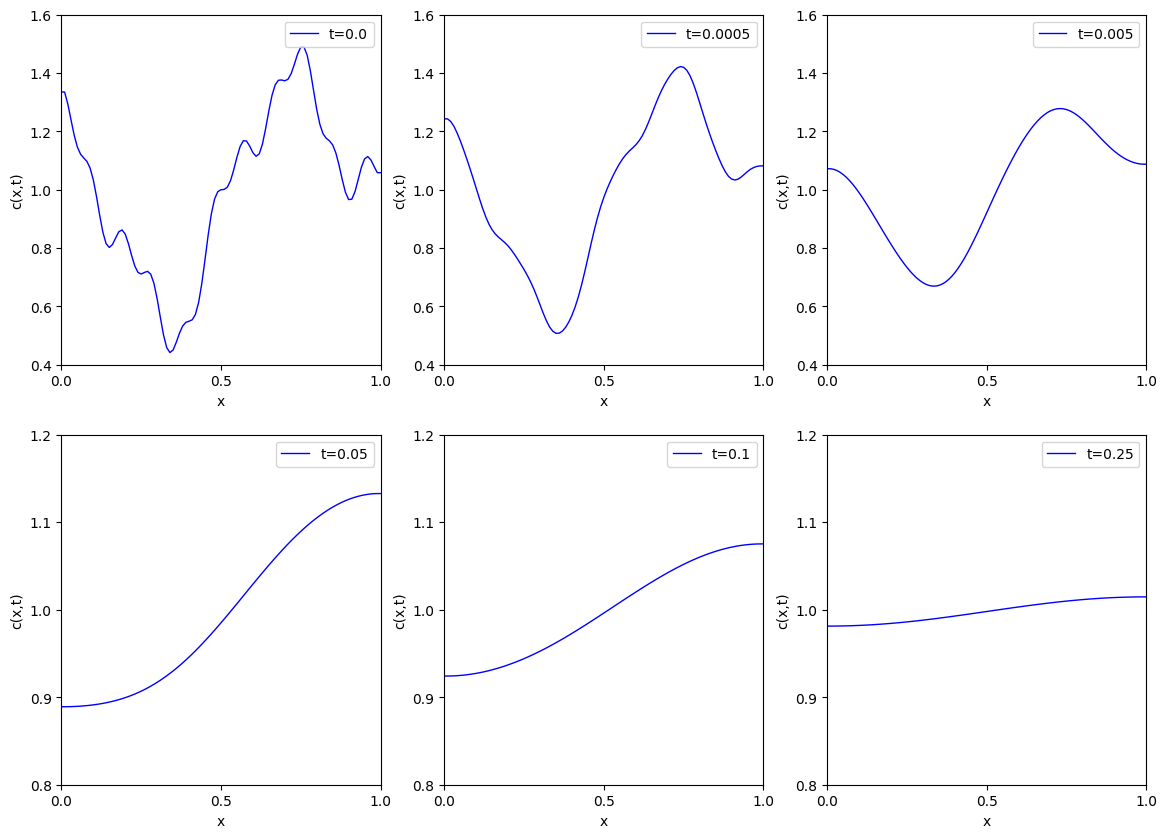

In [1]:
"""
多频模式扩散过程数值模拟程序（一维显式差分格式）
控制方程：∂c/∂t = α ∂²c/∂x² （α=dt/dx²，满足稳定性条件α=0.5）
边界条件：零梯度闭合边界（Neumann边界条件）
初始条件：多频余弦组合（含k=1,2,3,8,21波数成分）
"""

# 导入数值计算和可视化库
import numpy as np
import matplotlib.pyplot as plt

# ============== 参数初始化 ==============
Nx = 100             # 空间离散点数
Nt = 5000            # 时间步总数（相比之前案例增加时间步数）
L = 1.0              # 空间域长度
T = 0.25             # 时间域总长（增加模拟总时长）
dx = L / Nx          # 空间步长
dt = T / Nt          # 时间步长（更小的时间步长）

# 初始条件参数（未使用但保留变量）
mu = 0.5             # 保留参数（当前初始条件未使用）
sigma = 0.05         # 保留参数（当前初始条件未使用）


def initial_condition(x):
    """
    定义多频余弦组合的初始条件函数
    数学表达式:
        1 - 0.2cos(πx) + 0.1cos(2πx) + 0.3cos(3πx)
        + 0.1cos(8πx) + 0.05cos(21πx)
    特征说明:
        包含多个空间频率成分的叠加，用于测试数值耗散特性
    """
    return (
        1
        - 0.2 * np.cos(np.pi * x)
        + 0.1 * np.cos(2 * np.pi * x)
        + 0.3 * np.cos(3 * np.pi * x)
        + 0.1 * np.cos(8 * np.pi * x)
        + 0.05 * np.cos(21 * np.pi * x)
    )


# 初始化浓度场数组（时间维度 × 空间维度）
c = np.zeros((Nt + 1, Nx + 1))

# ============== 初始条件设置 ==============
# 在空间网格点设置初始值（跳过边界点）
for n in range(Nx - 1):
    c[0, n + 1] = initial_condition((n + 1) * dx)

# 设置零梯度边界条件
c[0, 0] = c[0, 1]        # 左边界
c[0, Nx] = c[0, Nx - 1]  # 右边界

# ============== 显式差分格式计算 ==============
alpha = dt / dx**2  # 计算稳定性参数（当前α=0.25满足稳定性）

# 主时间迭代循环
for i in range(Nt):
    # 空间节点更新（排除边界点）
    for j in range(1, Nx):
        # 应用显式差分公式更新浓度值
        c[i + 1, j] = (
            alpha * c[i, j - 1] + (1 - 2 * alpha) * c[i, j] + alpha * c[i, j + 1]
        )

    # 更新边界条件（保持零梯度）
    c[i + 1, 0] = c[i + 1, 1]        # 左边界
    c[i + 1, Nx] = c[i + 1, Nx - 1]  # 右边界

# ============== 多子图可视化 ==============
x = np.linspace(0, L, Nx + 1)  # 生成空间坐标数组
plt.figure(figsize=(14, 10))   # 创建大尺寸画布
plt.box(False)                 # 关闭整体画布边框
plt.axis(False)                # 隐藏主坐标系

# 创建2x3子图布局展示不同时刻状态
count = 1                      # 子图计数器
for i in [0, 10, 100, 1000, 2000, 5000]:
    plt.subplot(2, 3, count)   # 定位到指定子图

    # 绘制当前时刻的浓度分布曲线
    plt.plot(x, c[i, :], "b-", linewidth=1, label=f"t={i * dt}")
    plt.xlabel("x")            # x轴标签
    plt.ylabel("c(x,t)")       # y轴标签

    # 坐标轴范围设置
    plt.xlim(0, 1)             # 固定x轴范围
    plt.xticks([0, 0.5, 1])    # 简化x轴刻度

    # 动态调整y轴范围
    if count < 4:
        plt.ylim(0.4, 1.6)     # 前三个子图显示完整波动范围
    else:
        plt.ylim(0.8, 1.2)     # 后三个子图聚焦稳定区域
        plt.yticks([0.8, 0.9, 1.0, 1.1, 1.2])  # 细化y轴刻度

    plt.legend()  # 显示图例
    count += 1    # 更新子图计数器

plt.show()        # 显示完整图像


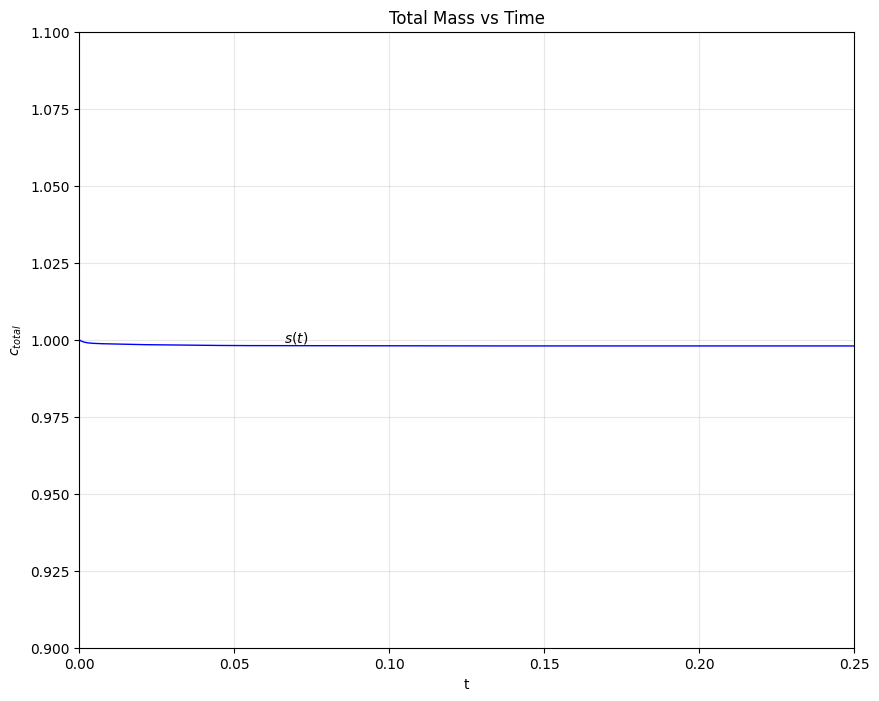

In [2]:
# ============== 总量计算模块 ==============
# 初始化总量数组（每个时间步对应的总量值）
s = np.zeros(Nt + 1)
# 生成时间坐标数组（从0到T均匀分布Nt+1个点）
t = np.linspace(0, T, Nt + 1)

# 使用复合辛普森法则进行数值积分
for i in range(Nt + 1):
    """
    复合辛普森积分公式实现：
    ∫c(x,t)dx ≈ (Δx/3)[c0 + 4c1 + 2c2 + 4c3 + ... + cn]
    代码实现等效形式：
    2*(总和 + 奇数项和) - 边界项，最后乘以dx/3
    """
    s[i] = (
        (
            2 * (np.sum(c[i, :]) + np.sum(c[i, :][1::2]))  # 计算全部节点和与奇数节点和
            - c[i, 0]
            - c[i, Nx]
        )
        * dx
        / 3
    )  # 修正边界项并应用辛普森系数

# ============== 总量变化可视化 ==============
plt.figure(figsize=(10, 8))
# 绘制总量随时间变化曲线
plt.plot(t, s, "b-", linewidth=1)
# 在t=0.07附近添加文本标注
plt.text(0.07, s[1400], "$s(t)$", ha="center", va="bottom", fontsize=10)  # 文本居中底部对齐

# 设置图表属性
plt.title("Total Mass vs Time")           # 设置标题
plt.xlabel("t")                           # x轴标签
plt.ylabel("$c_{total}$")                 # y轴标签（LaTeX格式）
plt.xlim(0, T)                            # x轴范围限制
plt.xticks(np.arange(0, T + 0.01, 0.05))  # 设置x轴刻度（步长0.01）
plt.ylim(0.9, 1.1)                        # y轴范围限制（显示守恒特性）
plt.grid(alpha=0.3)                       # 设置半透明网格线
plt.show()                                # 显示图表